# Part 5: PCA/POD

For the sake of curiosity, I will just apply PCA/POD on the same dataset of binary ellipses (with all three variables: size, axes and rotation). PCA is often used for dimension reduction but it is in essence a linear operation so the compression is not necessarily efficient. For the ellipses data, the three variables aren't linearly correlated with each other. So it is interesting to see what PCA can do.

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from skimage.transform import rotate

np.random.seed(42)

In [ ]:
def phantomEllipse(n, a, b, ang):
    x = np.arange(n)
    R = n // 2
    y = x[:, np.newaxis]
    img = (x-R)**2/a**2 + (y-R)**2/b**2
    img[img<=1] = 1
    img[img>1] = 0
    return rotate(img, angle=ang)

Since the eigendecomposition of the cross correlation matrix along the sample axis could be quite costly, I will limit the dataset to contain just 8000 samples.

In [ ]:
n = 64
num_batch = 16
batch_size = 500
N = int(num_batch * batch_size)
random_gen = np.random.default_rng()
a = random_gen.uniform(1, n//2, N)
b = random_gen.uniform(1, n//2, N)
ang = random_gen.uniform(0, 90, N)
dataset = np.array([phantomEllipse(n, _a, _b, _ang) for _a, _b, _ang in zip(a, b, ang)])

Let's look at a sample of 8 images from the dataset:

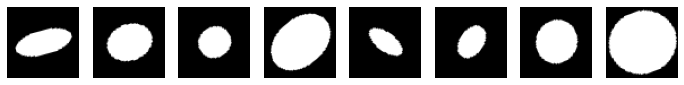

In [ ]:
frames = np.random.choice(np.arange(N), 8)
_, ax = plt.subplots(1, 8, figsize=(12, 3))
for i in range(8):
    ax[i].imshow(dataset[frames[i], ...], cmap=plt.get_cmap('gray'))
    ax[i].axis("off")
plt.show()

## PCA/POD

### Proper Orthogonal Decomposition (POD) with `numpy` and `numba`

PCA is a well known process and can be computed using a variety of libraries available (such as `scikit-learn`). Here I will just use `numpy` to demonstrate POD, which is a minor variant of PCA that focuses on extracting "eigenmodes" out of the decomposition. These eigenmodes are quite similar to the latent codes in autoencoders but have the advantage of preserving the input dimension and thus can *sometimes* be easily interpreted or associated with a physical phenomenon.

Notice that I chose to use the more conventional approach to construct the cross correlation matrix along the sample axis. However, it is computationally more efficient for this dataset to perform PCA/POD along the pixel axis, since there are about half the amount of pixels per image (4096) than the number of samples (8000). Nonetheless, I found out that by using `numba`, I could significantly speed up the calculation by parallelizing the eigendecomposition process (see below). It is however important to remember `compile` (i.e., execute) the decorated function once with a small subsample of the dataset before carrying out POD on the whole set. See `numba` [documentation](https://numba.readthedocs.io/en/stable/user/5minguide.html) for more details on how it works.



In [ ]:
@jit(nopython=True)
def eigendecomp(corr_mat, tol=1e-14):
    Lambda, Psi = np.linalg.eigh(corr_mat)
    eigvals = Lambda[::-1]
    eigvals = eigvals[eigvals > tol]

    proj_coeffs = np.fliplr(Psi)[:, :len(eigvals)] @ np.diag(eigvals**(0.5))

    return eigvals, proj_coeffs.T


def pod_modes(data_array):
    shape = np.shape(data_array)
    # reshape the data array
    data_array = np.reshape(data_array, [shape[0], np.prod(shape[1:])], order='F')
    # perform the decomposition
    corr_mat = data_array @ data_array.T
    eigvals, proj_coeffs = eigendecomp(corr_mat)
    num_of_modes = len(eigvals)

    Omega = np.diag(eigvals[:num_of_modes]**0.5)
    modes = Omega @ proj_coeffs[:num_of_modes, :] @ data_array
    modes = np.diag(eigvals[:num_of_modes]**(-1)) @ modes
    #modes = modes / (shape[0])**0.5*2
    modes = np.reshape(modes, [num_of_modes, *shape[1:]], order='F')

    return modes, eigvals, proj_coeffs

Now we can perform POD on the whole dataset and get the modes as well as the eigenvalues and projection coefficients, both of which will be needed for reduced-order reconstruction later.

In [ ]:
modes, eigvals, proj_coeffs = pod_modes(dataset)

## Decomposition Results

### Eigenvalues

So first let's have a look at the energy distribution among the eigenmodes.

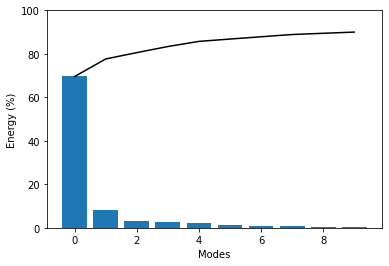

In [ ]:
eigvals = eigvals/eigvals.sum()*100
plt.bar(np.arange(10), eigvals[:10])
plt.plot(np.arange(10), eigvals.cumsum()[:10], 'k')
plt.ylim(0, 100)
plt.xlabel('Modes')
plt.ylabel('Energy (%)')
plt.show()

As can be seen, the first mode is by far the most prominent since it corresponds to the mean of the dataset (i.e., invariant part of the data). Usually the ensemble average would be subtracted prior to PCA/POD. But it is not necessary for our purpose in this notebook. Notice also that the cumulative sum of the energies (black line) tapers off very quickly in the first ten modes and hovers around 90%.

### Eigenmodes

Now let's look at the first 10 eigenmodes.

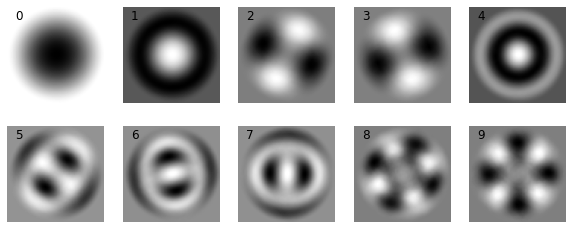

In [ ]:
_, ax = plt.subplots(2, 5, figsize=(10, 4))
for j in range(2):
    for i in range(5):
        frame = i+j*5
        ax[j, i].imshow(modes[frame, ...], cmap=plt.get_cmap('gray'))
        ax[j, i].text(5, 8, f"{frame}", fontsize=12)
        ax[j, i].axis("off")
plt.show()

As mentioned above, the first mode (Mode 0) can be correlated to the mean of the dataset (which is shown below). Note that the magnitude of the Mode 0 needs to be multiplied by -1 to match that of the average.

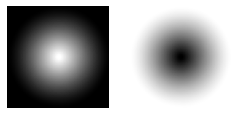

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(4, 3))
for i in range(2):
    ax[i].imshow(dataset.mean(axis=0)*(-1)**i, cmap=plt.get_cmap('gray'))
    ax[i].axis('off')
plt.show()

### Projection coefficients

Projection coefficients represent the "relevance" of a given eigenmode in a specific image. They fluctuate from image to image depending on the form and orientation of the ellipses. This is shown below for the first five modes. As can be seen, the "average" Mode 0 also varies quite significantly in intensity in this case.

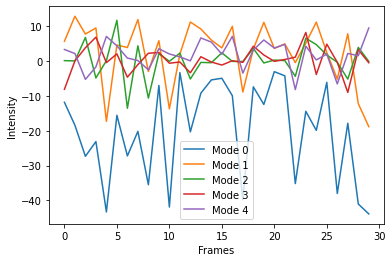

In [ ]:
for i in range(5):
    plt.plot(proj_coeffs[i, :30], label=f'Mode {i}')
plt.legend()
plt.xlabel('Frames')
plt.ylabel('Intensity')
plt.show()

## Reduced-order reconstruction

Since the input image can be reconstructed by linearly combining the eigenmodes, it is possible to use a subset of the eigenmodes to reduce the dimension of the dataset while preserving the most important features. We will look at 3 examples of different kinds of ellipses and see how many modes we need to employ to recreate well the original image.

### Example 1

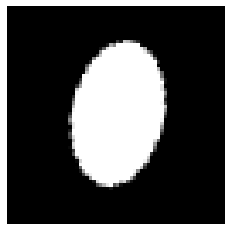

In [ ]:
frame = 1450
plt.imshow(dataset[frame, :], cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

Here we will compute the reconstruction by gradually adding more eigenmodes.

In [ ]:
def reconst_img(frame):
    reconst = []
    for i in range(len(eigvals)):
        reconst.append(modes[i, :]*proj_coeffs[i, frame]/eigvals[i]**0.5)

    return np.cumsum(reconst, axis=0)

Now we can have a look at the reconstructions with different number of eigenmodes:

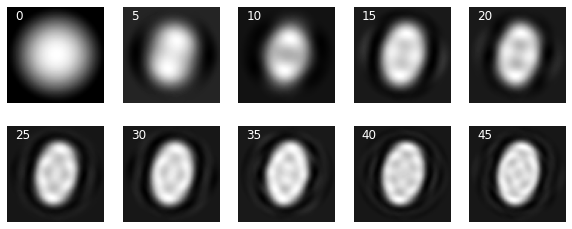

In [ ]:
reconst = reconst_img(frame)
_, ax = plt.subplots(2, 5, figsize=(10, 4))
for j in range(2):
    for i in range(5):
        _frame = i*5+j*5*5
        ax[j, i].imshow(reconst[_frame], cmap=plt.get_cmap('gray'))
        ax[j, i].axis("off")
        ax[j, i].text(5, 8, f"{_frame}", c="w", fontsize=12)
plt.show()

It is clear that the reconstruction doesn't evolve much beyond the first 10 modes (consistent with the observations made with the eigenvalues). Although with 10 modes we can already reconstruct the shape and orientation of the original ellipse, the image is blurry and distorted. This doesn't really get much better even with 45 modes.

We can see how many modes we need to have a "perfect" reconstruction (the original image is shown on the right):

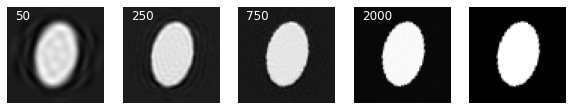

In [ ]:
_, ax = plt.subplots(1, 5, figsize=(10, 3))
frames = [50, 250, 750, 2000]
for i in range(4):
    ax[i].imshow(reconst[frames[i], ...], cmap=plt.get_cmap('gray'))
    ax[i].axis("off")
    ax[i].text(5, 8, f"{frames[i]}", c="w", fontsize=12)
ax[4].imshow(dataset[frame, :], cmap=plt.get_cmap('gray'))
ax[4].axis("off")
plt.show()

It shows above that we can reconstruct the shape with very high accuracy with around 750 eigenmodes but the intensity doesn't get to the correct level until we include some 2000 modes in the reconstruction. Depending on how much information loss we can afford, one might have to preserve a large number of eigenmodes. This trend can be seen in the following two other examples.

### Example 2

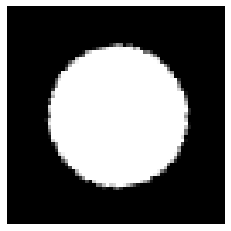

In [ ]:
frame = 450
plt.imshow(dataset[frame, :], cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

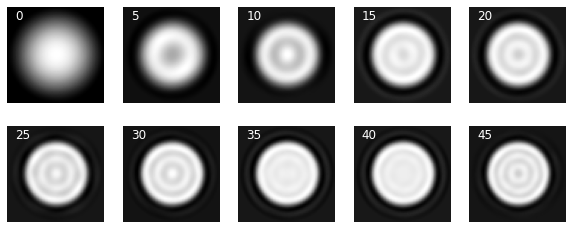

In [ ]:
reconst = reconst_img(frame)
_, ax = plt.subplots(2, 5, figsize=(10, 4))
for j in range(2):
    for i in range(5):
        _frame = i*5+j*5*5
        ax[j, i].imshow(reconst[_frame], cmap=plt.get_cmap('gray'))
        ax[j, i].axis("off")
        ax[j, i].text(5, 8, f"{_frame}", c="w", fontsize=12)
plt.show()

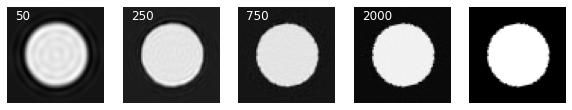

In [ ]:
_, ax = plt.subplots(1, 5, figsize=(10, 3))
frames = [50, 250, 750, 2000]
for i in range(4):
    ax[i].imshow(reconst[frames[i], ...], cmap=plt.get_cmap('gray'))
    ax[i].axis("off")
    ax[i].text(5, 8, f"{frames[i]}", c="w", fontsize=12)
ax[4].imshow(dataset[frame, :], cmap=plt.get_cmap('gray'))
ax[4].axis("off")
plt.show()

### Example 3

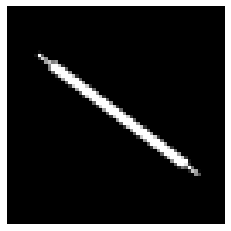

In [ ]:
frame = 2450
plt.imshow(dataset[frame, :], cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

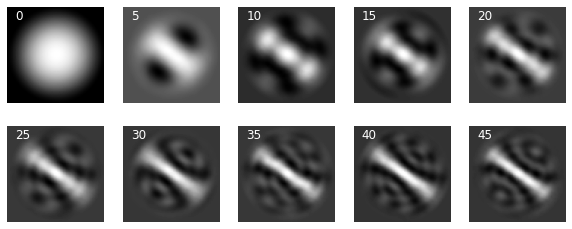

In [ ]:
reconst = reconst_img(frame)
_, ax = plt.subplots(2, 5, figsize=(10, 4))
for j in range(2):
    for i in range(5):
        _frame = i*5+j*5*5
        ax[j, i].imshow(reconst[_frame], cmap=plt.get_cmap('gray'))
        ax[j, i].axis("off")
        ax[j, i].text(5, 8, f"{_frame}", c="w", fontsize=12)
plt.show()

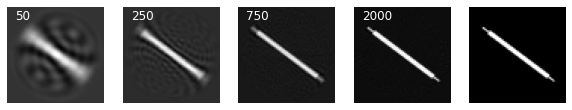

In [ ]:
_, ax = plt.subplots(1, 5, figsize=(10, 3))
frames = [50, 250, 750, 2000]
for i in range(4):
    ax[i].imshow(reconst[frames[i], ...], cmap=plt.get_cmap('gray'))
    ax[i].axis("off")
    ax[i].text(5, 8, f"{frames[i]}", c="w", fontsize=12)
ax[4].imshow(dataset[frame, :], cmap=plt.get_cmap('gray'))
ax[4].axis("off")
plt.show()

## Conclusions

So it is fairly clear at this point that, at least for this particular dataset, we can't really use 2-3 eigenmodes from linear PCA/POD to "encode" the dataset like we are (nearly) able to with the autoencoders presented in the first four parts of this series. 

Moreover, from the eigenmodes it is clear that linear PCA can't really identify the key features (size, axes and rotation) embedded into the dataset. Therefore, it is difficult if not impossible to comprehend these eigenmodes, just like in the case of standard autoencoders.

However, the turnover time of PCA is much shorter comparing to training and optimizing the PCA autoencoders may require. I would probably always apply PCA/POD first and see if I could achieve the desired feature extraction, especially when there exist features that are just linear superpositions of a few eigenmodes.  